In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw

In [3]:
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists

In [4]:
sns.set_context("notebook")

In [5]:
def rm_each_month_mean(ds):
    xy_mean = ds["thetao"].mean(dim=['latitude', 'longitude'], skipna=True)
    z_mean = xy_mean.mean(dim = "depth")
    return xy_mean - z_mean
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

In [6]:
import gsw

def sigma0_from_SP_and_pt0(z, SP, pt0, lon = 0, lat = 30):
    p = gsw.p_from_z(-abs(z), lat)
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_pt(SA,pt0)
    sigma0 = gsw.sigma0(SA,CT)
    return sigma0

In [7]:
%time
from pathlib import Path
from natsort import natsorted
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs


### Get NINO 3.4 Index

In [8]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

In [9]:
# theta_anom = remove_seasonal(theta_TS) #pot. temp anomaly
# salinity_anom = remove_seasonal(salinity_TS) #salinity anomaly
# sigma0_anom = remove_seasonal(sigma0_TS) #salinity anomaly

### Doing an EOF on this time period, see if a wave pattern appears along coastline around the time of 97 Nino event. EOF will be done on the 100m temperature 

In [10]:
def read_ds_ocn(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]].sel(depth = slice(50, 130))
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(26, 35))
        return ds_new

In [11]:
%%time 
n_cores = multiprocessing.cpu_count() - 5
NINO_97 = []
for year in ["1997", "1998", "1999"]:
    print(year)
    files = np.empty(0, dtype = str)
    for month in months:
        file_path = GLORYS_dir + "/" + year + "/" + month
        file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
        files = np.concatenate([files, file_list])
    files = natsorted([str(f) for f in files])
    if __name__ == '__main__':
        with Pool(n_cores) as p:
            datasets = p.map(read_ds_ocn, files)
    datasets = [d for d in datasets]
    NINO_97 = NINO_97 + datasets #about 50 gigs of data!! 
    


1997
1998
1999
CPU times: user 675 ms, sys: 500 ms, total: 1.18 s
Wall time: 13.3 s


In [19]:
%%time 
NINO_97_ds = xr.concat(NINO_97, dim = "time", data_vars = "minimal", coords = "minimal")
NINO_97_ds = NINO_97_ds.sortby("time")

CPU times: user 3.32 s, sys: 1.88 s, total: 5.21 s
Wall time: 59.7 s


In [13]:
# z = -NINO_97_ds.depth
# SP = NINO_97_ds.so
# pt0 = NINO_97_ds.thetao
# sigma0_NINO97 = sigma0_from_SP_and_pt0(z, SP, pt0)
# sigma0_NINO97 = sigma0_NINO97.rename("sigma0")

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
nt = len(sigma0_NINO97.time)
nd = len(sigma0_NINO97.depth)
nlat = len(NINO_97_ds.latitude)
nlon = len(NINO_97_ds.longitude)

depth = sigma0_NINO97.depth
#construct depth grid 
z_grid = np.zeros((nt, nd, nlat, nlon))
for i in range(0, nd):
    z_grid[:, i, :, :] = -depth[i]
SP = NINO_97_ds.so.values
pt0 = NINO_97_ds.thetao.values

sigma0 = sigma0_from_SP_and_pt0(z_grid, SP, pt0)



In [109]:
%%time 
from scipy import interpolate 

D_sigma = np.zeros((nt, nlat, nlon))
y = -np.abs(depth)

#could possibly parallize this? 3 times faster if using 3 cores would use about 18 gbs of ram 
for it in range(0, 200):
    print(it) if it % 100 == 0 else _
    for ilon in range(0, nlon):
        for ilat in range(0, nlat):
            x = sigma0[it, :, ilat, ilon]
            if np.all(np.diff(x) > 0): #checks if monotonic 
                f = interpolate.interp1d(x, y, axis=0, bounds_error = False, fill_value = np.nan, assume_sorted = True)
                D_sigma[it, ilat, ilon] = f(25.0)
            else:
                D_sigma[it, ilat, ilon] = np.nan

0
100
CPU times: user 6min 39s, sys: 257 ms, total: 6min 39s
Wall time: 6min 39s


array([[  0.        ,   0.        ,   0.        , ..., -13.00227776,
        -13.0121254 , -13.05453613],
       [  0.        ,   0.        ,   0.        , ..., -12.79747789,
        -12.85658244, -12.78997883],
       [  0.        ,   0.        ,   0.        , ..., -12.64216805,
        -12.71133086, -12.66081899],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

MovieWriter imagemagick unavailable; using Pillow instead.


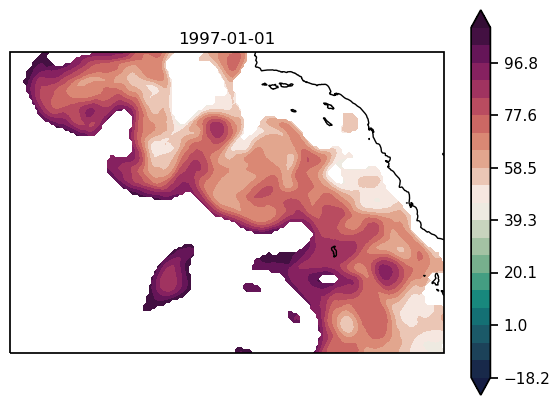

In [121]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.style.use('seaborn-pastel')

NINO34_97 = remove_seasonal(NINO34).interp(time = sigma0_NINO97.time)

fig,axes = plt.subplots(figsize = (7, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})
axes.coastlines()

data = np.abs(D_sigma) - np.nanmean(np.abs(D_sigma), axis = 0)

times = sigma0_NINO97.time.values
times = pd.to_datetime(times).strftime('%Y-%m-%d')

LONS, LATS = np.meshgrid(sigma0_NINO97.longitude, sigma0_NINO97.latitude)
lbound, ubound = np.nanmin(data), np.nanmax(data)
levels = np.linspace(lbound, ubound, 21)
cf = axes.contourf(LONS, LATS, data[0, :, :], vmin = lbound, vmax = ubound, levels = levels, cmap=cm.curl, extend = "both")
fig.colorbar(cf, ax=axes)
    
def animate(i):
    axes.clear()
    axes.coastlines()

    fontweight = "normal" if NINO34_97[i] < 0.5 else "bold"
    axes.set_title(times[i], fontweight = fontweight)
    cf = axes.contourf(LONS, LATS, data[i, :, :], vmin = lbound, vmax = ubound, levels = levels, cmap=cm.curl, extend = "both")
    return cf
anim = FuncAnimation(fig, animate,
                               frames=200, interval=10, blit=False)
anim.save('sigma25_depth.gif', writer='imagemagick')